<a href="https://colab.research.google.com/github/Somabss1/AIML/blob/main/GoogleGemini/Google_gemini_Haystack_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install haystack-ai haystack-experimental sentence-transformers transformers gradio huggingface_hub cohere-haystack
!pip install python-dotenv colorama trafilatura


ERROR: Could not find a version that satisfies the requirement install (from versions: none)
ERROR: No matching distribution found for install


In [18]:
!pip install google-ai-haystack


ERROR: Could not find a version that satisfies the requirement haystack_integrations (from versions: none)
ERROR: No matching distribution found for haystack_integrations


In [14]:
import warnings
#from helper import load_env

warnings.filterwarnings('ignore')
#load_env()

In [28]:
import requests
import os

from typing import List

from haystack import Document, Pipeline, component
from haystack.components.builders import PromptBuilder
from haystack.components.generators.openai import OpenAIGenerator
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
import google.generativeai as genai
from haystack_integrations.components.generators.google_ai import GoogleAIGeminiGenerator


In [23]:
from google.colab import userdata
genai.configure(api_key=userdata.get("GOOGLE_API_KEY"))

In [5]:
trending_list = requests.get(
        url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty"
    )
post = requests.get(
    url=f"https://hacker-news.firebaseio.com/v0/item/{trending_list.json()[0]}.json?print=pretty"
)

print(post.json())

{'by': 'nell', 'descendants': 36, 'id': 41330478, 'kids': [41330893, 41330698, 41330995, 41330925, 41330663, 41330664, 41330899, 41330644, 41330655, 41330829, 41330728, 41330959, 41330479, 41330888, 41330764, 41330742], 'score': 63, 'time': 1724431098, 'title': 'Cautionary tale on using Chase bank for indie business', 'type': 'story', 'url': 'https://jxnl.co/writing/2024/09/21/chase-bank-small-business-nightmare/'}


In [6]:
@component
class HackernewsNewestFetcher:
    @component.output_types(articles=List[Document])
    def run(self, top_k: int):
        articles = []
        return {"articles": articles}

In [37]:
@component
class HackernewsNewestFetcher:
    def __init__(self):
        fetcher = LinkContentFetcher()
        converter = HTMLToDocument()

        html_conversion_pipeline = Pipeline()
        html_conversion_pipeline.add_component("fetcher", fetcher)
        html_conversion_pipeline.add_component("converter", converter)

        html_conversion_pipeline.connect("fetcher", "converter")
        self.html_pipeline = html_conversion_pipeline

    @component.output_types(articles=List[Document])
    def run(self, top_k: int):
        articles = []
        trending_list = requests.get(
            url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty"
        )
        for id in trending_list.json()[0:top_k]:
            post = requests.get(
                url=f"https://hacker-news.firebaseio.com/v0/item/{id}.json?print=pretty"
            )
            if "url" in post.json():
                try:
                    article = self.html_pipeline.run(
                        {"fetcher": {"urls": [post.json()["url"]]}}
                    )
                    articles.append(article["converter"]["documents"][0])
                except:
                    print(f"Can't download {post}, skipped")
            elif "text" in post.json():
                try:
                    articles.append(Document(content=post.json()["text"], meta= {"title": post.json()["title"]}))
                except:
                    print(f"Can't download {post}, skipped")
        return {"articles": articles}

In [38]:
fetcher = HackernewsNewestFetcher()
results = fetcher.run(top_k=3)

print(results['articles'])

[Document(id=a515523a5138ce22a9c09d0b6d39e157d03a4da00362a0bbb335637aed4f09c2, content: 'The goal of this project is to reimplement enough of the original Unreal Engine to make the Unreal T...', meta: {'content_type': 'text/html', 'url': 'https://github.com/dpjudas/SurrealEngine'}), Document(id=4b9b4b202e14cf359feaef2606909cec2c146b2cf8f986abdf946954ba6e478b, content: 'OpenSSH Backdoors
Imagine this: an OpenSSH backdoor is discovered, maintainers rush to push out a fi...', meta: {'content_type': 'text/html', 'url': 'https://blog.isosceles.com/openssh-backdoors/'}), Document(id=eff933fc722511b1297f5f20305a1328f777cfc0bce13643b29607fe8e175dc4, content: '23 August 2024
A page is the granularity at which an operating system manages memory. Most CPUs toda...', meta: {'content_type': 'text/html', 'url': 'https://android-developers.googleblog.com/2024/08/adding-16-kb-page-size-to-android.html'})]


In [40]:
prompt_template = """
You will be provided a few of the top posts in HackerNews.
For each post, provide a brief summary if possible.

Posts:
{% for article in articles %}
  Post:\n
  {{ article.content}}
{% endfor %}
"""

In [29]:
os.environ["GOOGLE_API_KEY"] =  "<your_google_api_key"
prompt_builder = PromptBuilder(template=prompt_template)
fetcher = HackernewsNewestFetcher()
llm = GoogleAIGeminiGenerator(model="gemini-1.5-flash")




summarizer_pipeline = Pipeline()
summarizer_pipeline.add_component("fetcher", fetcher)
summarizer_pipeline.add_component("prompt", prompt_builder)
summarizer_pipeline.add_component("llm", llm)

summarizer_pipeline.connect("fetcher.articles", "prompt.articles")
summarizer_pipeline.connect("prompt", "llm")

🚅 Components
  - fetcher: HackernewsNewestFetcher
  - prompt: PromptBuilder
  - llm: GoogleAIGeminiGenerator
🛤️ Connections
  - fetcher.articles -> prompt.articles (List[Document])
  - prompt.prompt -> llm.parts (str)

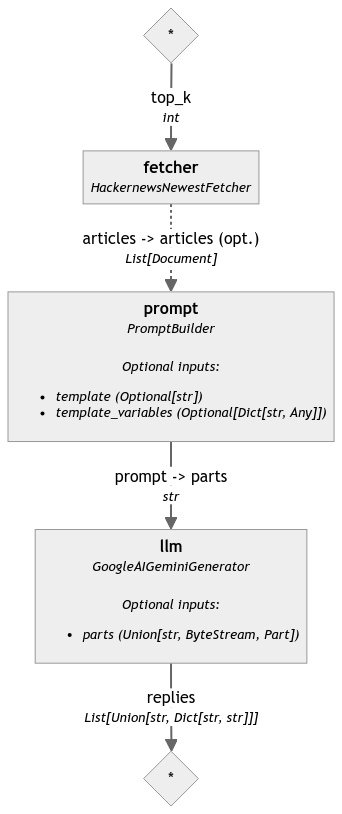

In [30]:
summarizer_pipeline.show()

In [31]:
summaries = summarizer_pipeline.run({"fetcher": {"top_k": 3}})

print(summaries["llm"]["replies"][0])

## HackerNews Post Summaries:

**Post 1: Unreal Engine Reimplementation - SurrealEngine**

This post introduces SurrealEngine, a project aiming to reimplement enough of the original Unreal Engine to make Unreal Tournament (UT99) maps playable. The project is still under development, but it can already load and render maps, and the Unrealscript VM is almost complete. While many features are missing, it's possible to play UT99 and Unreal Gold to some extent. The post provides instructions on how to build and run SurrealEngine, as well as its dependencies for both Windows and Linux.

**Post 2: Chasing Chase: A Yuppie Nightmare with Banking**

This post recounts the author's harrowing experience with Chase Bank, where $180,000 of their business account was frozen without warning or explanation. The author describes the frustrating and drawn-out process of trying to recover their funds, facing various excuses and demands from Chase. Ultimately, they recovered the money after months of persi

In [41]:
prompt_template = """
You will be provided a few of the top posts in HackerNews, followed by their URL.
For each post, provide a brief summary followed by the URL the full post can be found at.

Posts:
{% for article in articles %}
  {{ article.content }}
  URL: {{ article.meta["url"] }}
{% endfor %}
"""

prompt_builder = PromptBuilder(template=prompt_template)
fetcher = HackernewsNewestFetcher()
#llm = OpenAIGenerator()
llm = GoogleAIGeminiGenerator(model="gemini-1.5-flash")

summarizer_pipeline = Pipeline()
summarizer_pipeline.add_component("fetcher", fetcher)
summarizer_pipeline.add_component("prompt", prompt_builder)
summarizer_pipeline.add_component("llm", llm)

summarizer_pipeline.connect("fetcher.articles", "prompt.articles")
summarizer_pipeline.connect("prompt", "llm")

🚅 Components
  - fetcher: HackernewsNewestFetcher
  - prompt: PromptBuilder
  - llm: GoogleAIGeminiGenerator
🛤️ Connections
  - fetcher.articles -> prompt.articles (List[Document])
  - prompt.prompt -> llm.parts (str)

In [43]:
summaries = summarizer_pipeline.run({"fetcher": {"top_k": 2}})

print(summaries["llm"]["replies"][0])

## HackerNews Post Summaries:

**1. SurrealEngine: A Reimplementation of the Unreal Engine 1**

This project aims to reimplement the Unreal Engine 1, focusing on making Unreal Tournament (UT99) maps playable. It can load and render maps, and the Unrealscript VM is almost complete.  While many native functions are still missing, the engine can run UT99 and Unreal Gold in a somewhat playable state.

**URL:** https://github.com/dpjudas/SurrealEngine

**2. OpenSSH Backdoors: A Historical Perspective on Supply Chain Attacks**

This blog post recounts two instances of backdoors in the OpenSSH project. The first, from 2002, involved a simple backdoor inserted into the source code hosted on ftp.openbsd.org. The second, the xz-utils backdoor, involved a more sophisticated social engineering campaign targeting the liblzma library, ultimately aiming to compromise OpenSSH. The article discusses the similarities and differences between these two attacks, highlighting the evolution of supply chain a